In [1]:
from pennylane.optimize import AdamOptimizer,QNSPSAOptimizer,AdagradOptimizer
import pennylane as qml
from pennylane import numpy as np
import pandas as pd
import jax
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error as mse
from scipy.optimize import minimize
from IPython.display import clear_output
import random 
from pennylane.optimize import AdamOptimizer,QNSPSAOptimizer
from utils import *
from autoencoder import Autoencoder
from autoencoder2 import Autoencoder_c11
import warnings
warnings.filterwarnings("ignore")
import os 

In [2]:
custom_palette =['#EABFCB','#C191A1','#A4508B','#5F0A87','#2F004F','#120021',]

In [3]:
range_qubit_autoencoder=list(range(2,8))
range_batches = [10,20,50,100]
seed=42
epochs=10
n=100
stepsize=.2
opt=AdamOptimizer(stepsize=.2)
X=np.random.rand(n)*2*np.pi


In [4]:
import time


Running AE with 2 input qubit and 1 trash qubit in batches of 10
the device has 4 qubits
Epoch 10, Batch:9 Loss = 0.0022831634852919876
--------------------------------------------------
Running AE with 2 input qubit and 1 trash qubit in batches of 20
the device has 4 qubits
Epoch 10, Batch:4 Loss = 0.0010707851840493442
--------------------------------------------------
Running AE with 2 input qubit and 1 trash qubit in batches of 50
the device has 4 qubits
Epoch 10, Batch:1 Loss = 0.0060592920453910425
--------------------------------------------------
Running AE with 2 input qubit and 1 trash qubit in batches of 100
the device has 4 qubits
Epoch 10, Batch:0 Loss = 0.01437463737783061
--------------------------------------------------
Running AE with 3 input qubit and 1 trash qubit in batches of 10
the device has 5 qubits


DecompositionUndefinedError: 

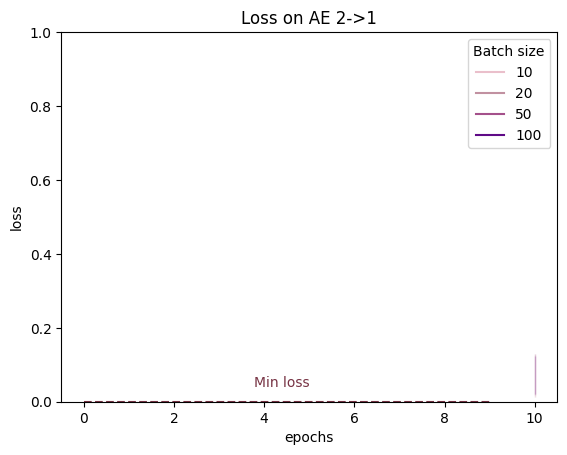

In [5]:
for n_qubit_autoencoder in range_qubit_autoencoder:
    for n_trash_qubit in range(1,n_qubit_autoencoder):
        batch_losses={}
        batch_times={}
        img_folder=f'runs/run_{n_qubit_autoencoder}to{n_qubit_autoencoder-n_trash_qubit}'
        os.makedirs(img_folder,exist_ok=True)
        for batch_size in range_batches:
            folder=img_folder+f'/{batch_size}'
            print(f"Running AE with {n_qubit_autoencoder} input qubit and {n_trash_qubit} trash qubit in batches of {batch_size}")
            n_qubit=n_qubit_autoencoder+n_trash_qubit+1 
            dvc = qml.device('default.qubit', wires=n_qubit, shots=None)
            ae = Autoencoder_c11('c11',n_qubit_autoencoder,n_trash_qubit,dvc,seed)

            start_time = time.time()
            ae.train(X,opt,epochs,batch_size)
            end_time = time.time()

            os.makedirs(folder)
            loss=ae.get_loss()
            batch_losses[batch_size]=loss
            batch_times[batch_size]=end_time-start_time
            weights=ae.best_params()
            np.save(folder+'/loss',np.array(loss))            
            np.save(folder+'/weights',np.array(weights))

        # Min loss
        min_found= {a:min(batch_losses[a]) for a in range_batches }
        min_loss =get_min_loss_fid(X,n_qubit_autoencoder,n_trash_qubit)

        # Figure
        plt.figure()
        sns.set_palette(custom_palette)  
        for b,r in zip(list(batch_losses.values()),range_batches):
            sns.lineplot(x=range(len(b)),y=b,label=r)
        plt.legend(title='Batch size')
        plt.hlines(min_loss,0,epochs-1,color='#773344',linestyle='--')
        plt.text(x=epochs//2, y=min_loss+0.05, fontsize='medium', s=f'Min loss', color='#773344', ha='right', va='center')
        plt.ylim((0,1))

        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.title(f'Loss on AE {n_qubit_autoencoder}->{n_qubit_autoencoder-n_trash_qubit}')
        plt.savefig(img_folder+f'/{n_qubit_autoencoder}_{n_qubit_autoencoder-n_trash_qubit}')
        # Info file 
        with open(img_folder+f'/info.txt','a') as file:
            file.write(f'RUN INFORMATION\nInput qubits={n_qubit_autoencoder}\nTrash qubit={n_trash_qubit}\nSeed={seed}\nOptimizer=AdamOptimizer(stepsize={opt.stepsize})\nEpochs={epochs}\nBatch sizes={range_batches}\nMin fidelity loss={min_loss}\nMin loss found=\n{''.join([f'\t\t\t\t{a}\t:\t{b}\n' for a, b in min_found.items()])}\nExec (training) time=\n{''.join([f'\t\t\t\t{a}\t:\t{b}\n' for a, b in batch_times.items()])}')

In [11]:
dir(opt)


['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_update_accumulation',
 'accumulation',
 'apply_grad',
 'beta1',
 'beta2',
 'compute_grad',
 'eps',
 'fm',
 'reset',
 'sm',
 'step',
 'step_and_cost',
 'stepsize',
 't']